In [1]:
# Download dataset using kaggle api

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/كولاب/lesson/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download arpitjain007/dog-vs-cat-fastai
!unzip /content/dog-vs-cat-fastai.zip

Streaming output truncated to the last 5000 lines.
  inflating: dogscats/train/dogs/dog.7066.jpg  
  inflating: dogscats/train/dogs/dog.7067.jpg  
  inflating: dogscats/train/dogs/dog.7068.jpg  
  inflating: dogscats/train/dogs/dog.7069.jpg  
  inflating: dogscats/train/dogs/dog.707.jpg  
  inflating: dogscats/train/dogs/dog.7070.jpg  
  inflating: dogscats/train/dogs/dog.7071.jpg  
  inflating: dogscats/train/dogs/dog.7072.jpg  
  inflating: dogscats/train/dogs/dog.7073.jpg  
  inflating: dogscats/train/dogs/dog.7074.jpg  
  inflating: dogscats/train/dogs/dog.7075.jpg  
  inflating: dogscats/train/dogs/dog.7076.jpg  
  inflating: dogscats/train/dogs/dog.7077.jpg  
  inflating: dogscats/train/dogs/dog.7078.jpg  
  inflating: dogscats/train/dogs/dog.7079.jpg  
  inflating: dogscats/train/dogs/dog.708.jpg  
  inflating: dogscats/train/dogs/dog.7080.jpg  
  inflating: dogscats/train/dogs/dog.7081.jpg  
  inflating: dogscats/train/dogs/dog.7082.jpg  
  inflating: dogscats/train/dogs/dog.70

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Input,BatchNormalization,MaxPooling2D,Conv2D,Dropout,MaxPool2D
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
# Creat function to preprocessing Data
def preprocessing(img_dims, batch_size):
  # Data generation objects
  train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
  test_val_datagen = ImageDataGenerator(rescale=1./255)

  # Path Data train&test
  path_train = '/content/dogscats/train'
  path_test = '/content/dogscats/valid'

  # generating images and give label for images
  train_gen = train_datagen.flow_from_directory(
  directory=path_train,
  target_size=(img_dims, img_dims),
  batch_size=batch_size,
  class_mode='binary',
  shuffle=True)

  test_gen = test_val_datagen.flow_from_directory(
  directory= path_test,
  target_size=(img_dims, img_dims),
  batch_size=batch_size,
  class_mode='binary',
  shuffle=True)

  return train_gen,test_gen

In [4]:
img_dims=64
batch_size=32
train_gen,test_gen =  preprocessing(img_dims,batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


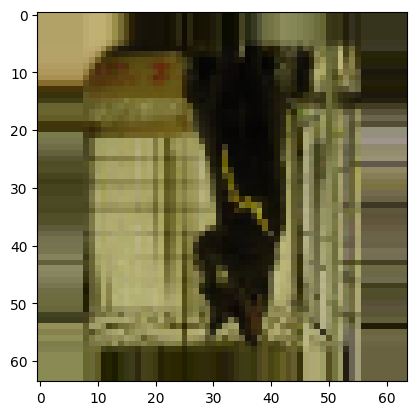

In [5]:
index = 0 # The max number for index is 719
img = train_gen[index][0]
plt.imshow(img[10])
plt.show()

In [7]:
# Model structure

#inpu layer
inputs = Input(shape=(img_dims,img_dims, 3))
#Conv2D layer 1
x = Conv2D(16,(3,3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(16,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

#Conv2D layer 2
x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

#Conv2D layer 3
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)

#Conv2D layer 4
x = Conv2D(128,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2))(x)



#Flatten Layers
x = Flatten()(x)
x = Dropout(0.2)(x)

#Fully Concented Layers
x = Dense(1024,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.3)(x)

#Output layer

output = Dense(1,activation='sigmoid')(x)
#creat model
model = Model(inputs,output)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0     

In [9]:
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [10]:
# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=10,
           validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size ,
           callbacks=[checkpoint, lr_reduce]
           )

Epoch 1/10
718/718 [==============================] - 142s 171ms/step - loss: 0.7095 - binary_accuracy: 0.5537 - val_loss: 0.7562 - val_binary_accuracy: 0.5514 - lr: 0.0010
Epoch 2/10
718/718 [==============================] - 115s 160ms/step - loss: 0.6248 - binary_accuracy: 0.6569 - val_loss: 0.6539 - val_binary_accuracy: 0.6159 - lr: 0.0010
Epoch 3/10
718/718 [==============================] - ETA: 0s - loss: 0.5674 - binary_accuracy: 0.7187
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
718/718 [==============================] - 116s 162ms/step - loss: 0.5674 - binary_accuracy: 0.7187 - val_loss: 0.5756 - val_binary_accuracy: 0.6522 - lr: 0.0010
Epoch 4/10
718/718 [==============================] - 107s 149ms/step - loss: 0.4989 - binary_accuracy: 0.7673 - val_loss: 0.4885 - val_binary_accuracy: 0.7576 - lr: 3.0000e-04
Epoch 5/10
718/718 [==============================] - ETA: 0s - loss: 0.4696 - binary_accuracy: 0.7862
Epoch 5: ReduceLROnPlateau reduci

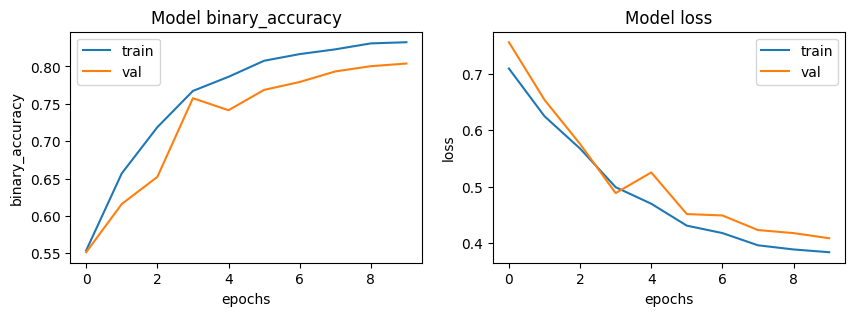

In [11]:
# Visualize results

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

for i, met in enumerate(['binary_accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
# Saving model
model.save('classification_Dog_vs_Cat.h5')